# Where should a chef open a restaurant in Toronto?

## Introduction/Business Problem

French Chef Jacques Durand wishes to open a new French restaurant in Toronto called _La Bonne Cuisine_.

In order to ensure the restaurant's success, he hired a data scientist to analyze the most successful restaurants in Toronto, their location.

One particularly interesting aspect will be to see if French restaurants are more successful in one neighborhood or another.

## Data Analysis Overview

This project will leverage the [Foursquare Venue](https://developer.foursquare.com/docs/api/venues/details) API to collect:
* Metrics about successful restaurants (e.g. cuisine, stats, ratings)
* Location of those restaurants 

Based on these metrics we will build a model that predicts the chances success of a restaurant of a certain cuisine (French in particular) 

# Section I: Data Engineering

## Import libraries and data

In [1]:
# Data Engineering Libraries
import numpy as np
import pandas as pd

# Libraries for web calls/scraping
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize

# Geolocation libraries
from geopy.geocoders import Nominatim 
import folium

# Plotting libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# ML Libraries

print('Libraries imported.')

Libraries imported.


## Getting Toronto Neighborhood data

In [2]:
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [3]:
soup = BeautifulSoup(page.content, 'html.parser')

In [4]:
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df_clean = df[df['Borough'] != 'Not assigned']
df_clean.head()

Postcode           Borough     Neighbourhood
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M5A  Downtown Toronto       Regent Park
6      M6A        North York  Lawrence Heights

In [5]:
lat_lng_df = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_df.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

## Extract relevant fields

In [6]:
# define the dataframe columns
column_names = ['PostalCode','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
# Merging latitude and longitude data into one frame

for index, row in df_clean.iterrows():
    post_code = row['Postcode'] 
    borough = row['Borough'] 
    neighborhood_name = row['Neighbourhood']
    
    lat_long = lat_lng_df.loc[lat_lng_df['Postal Code'] == post_code]

    borough_lat = lat_long['Latitude'].values[0]
    borough_lon = lat_long['Longitude'].values[0]
    
    neighborhoods = neighborhoods.append({'PostalCode': post_code,
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': borough_lat,
                                          'Longitude': borough_lon}, ignore_index=True)
    
neighborhoods.head()

PostalCode           Borough      Neighborhood   Latitude  Longitude
0        M3A        North York         Parkwoods  43.753259 -79.329656
1        M4A        North York  Victoria Village  43.725882 -79.315572
2        M5A  Downtown Toronto      Harbourfront  43.654260 -79.360636
3        M5A  Downtown Toronto       Regent Park  43.654260 -79.360636
4        M6A        North York  Lawrence Heights  43.718518 -79.464763

In [8]:
# Flattening by PostalCode

tmp = neighborhoods[['PostalCode', 'Latitude', 'Longitude']]
tmp = tmp.drop_duplicates()

postalcodes = pd.DataFrame(columns=column_names)

for index, row in tmp.iterrows():
    post_code = row['PostalCode'] 
    borough = neighborhoods.loc[neighborhoods['PostalCode'] == post_code]['Borough'].values.flatten()
    neighborhood_name = neighborhoods.loc[neighborhoods['PostalCode'] == post_code]['Neighborhood'].values.flatten()
    borough_lat = row['Latitude']
    borough_lon = row['Longitude']
    
    postalcodes = postalcodes.append({'PostalCode': post_code,
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': borough_lat,
                                          'Longitude': borough_lon}, ignore_index=True)
    
postalcodes.head()


PostalCode                               Borough  \
0        M3A                          [North York]   
1        M4A                          [North York]   
2        M5A  [Downtown Toronto, Downtown Toronto]   
3        M6A              [North York, North York]   
4        M7A                        [Queen's Park]   

                         Neighborhood   Latitude  Longitude  
0                         [Parkwoods]  43.753259 -79.329656  
1                  [Victoria Village]  43.725882 -79.315572  
2         [Harbourfront, Regent Park]  43.654260 -79.360636  
3  [Lawrence Heights, Lawrence Manor]  43.718518 -79.464763  
4                      [Not assigned]  43.662301 -79.389494

# Section II: Data Vizualization

### Using geopy library to get the latitude and longitude values of Toronto

In [9]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
toronto_location = geolocator.geocode(address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


## Creating a map to vizualize the different zipcodes

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(postalcodes['Latitude'], postalcodes['Longitude'], postalcodes['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Connecting to Foursquare

In [11]:
CLIENT_ID = '2RTVW4MQWUB4HHSG5BJUIBNXO4EDACHOXJ1GQ5PWOJ0VVBDT' # your Foursquare ID
CLIENT_SECRET = 'IOVG5OQTNEBTVUB0ZGVUVQOKXU41VXAVWXKTQRHMDSALU1TL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2RTVW4MQWUB4HHSG5BJUIBNXO4EDACHOXJ1GQ5PWOJ0VVBDT
CLIENT_SECRET:IOVG5OQTNEBTVUB0ZGVUVQOKXU41VXAVWXKTQRHMDSALU1TL


In [12]:
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    toronto_latitude, 
    toronto_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=2RTVW4MQWUB4HHSG5BJUIBNXO4EDACHOXJ1GQ5PWOJ0VVBDT&client_secret=IOVG5OQTNEBTVUB0ZGVUVQOKXU41VXAVWXKTQRHMDSALU1TL&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

## Getting all venues data in the Toronto region

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d5aa816787dba00336b0b11'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 73,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name        categories        lat        lng
0          Downtown Toronto      Neighborhood  43.653232 -79.385296
1                   Japango  Sushi Restaurant  43.655268 -79.385165
2  Textile Museum of Canada        Art Museum  43.654396 -79.386500
3                 Poke Guys        Poke Place  43.654895 -79.385052
4        Sansotei Ramen 三草亭  Ramen Restaurant  43.655157 -79.386501

In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

73 venues were returned by Foursquare.


## Getting venues of type restaurant per postal code  

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
     
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=postalcodes['PostalCode'],
                                   latitudes=postalcodes['Latitude'],
                                   longitudes=postalcodes['Longitude']
                                  )

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(2237, 8)


PostalCode  PostalCode Latitude  PostalCode Longitude  \
0        M3A            43.753259            -79.329656   
1        M3A            43.753259            -79.329656   
2        M3A            43.753259            -79.329656   
3        M4A            43.725882            -79.315572   
4        M4A            43.725882            -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4             Tim Hortons       43.725517       -79.313103   

         Venue Category                  Venue ID  
0                  Park  4e8d9dcdd5fbbbb6b3003c7b  
1  Fast Food Restaurant  4e6696b6d16433b9ffff47c3  
2     Food & Drink Shop  4cb11e2075ebb60cd1c4caad  
3          Hockey Arena  4c633acb86b6be9a61268e34  
4           Coffee Shop  4bbe904a85fbb713420d7167

## Looking at the type of restaurant venues

In [20]:
toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant')].groupby('Venue Category').count()

PostalCode  PostalCode Latitude  \
Venue Category                                                     
Afghan Restaurant                         1                    1   
American Restaurant                      28                   28   
Asian Restaurant                         15                   15   
Brazilian Restaurant                      2                    2   
Cajun / Creole Restaurant                 1                    1   
Caribbean Restaurant                      9                    9   
Chinese Restaurant                       26                   26   
Colombian Restaurant                      2                    2   
Comfort Food Restaurant                   8                    8   
Cuban Restaurant                          2                    2   
Dim Sum Restaurant                        2                    2   
Doner Restaurant                          1                    1   
Dumpling Restaurant                       4                    4   
Eastern European Restaurant               3                    3   
Empanada Restaurant                       1                    1   
Ethiopian Restaurant                      2                    2   
Falafel Restaurant                        3                    3   
Fast Food Restaurant                     37                   37   
Filipino Restaurant                       1                    1   
French Restaurant                        12                   12   
German Restaurant                         1                    1   
Gluten-free Restaurant                    3                    3   
Greek Restaurant                         18                   18   
Hakka Restaurant                          1                    1   
Hotpot Restaurant                         1                    1   
Indian Restaurant                        15                   15   
Indonesian Restaurant                     1                    1   
Italian Restaurant                       52                   52   
Japanese Restaurant                      33                   33   
Jewish Restaurant                         1                    1   
Korean Restaurant                         4                    4   
Latin American Restaurant                 7                    7   
Malay Restaurant                          1                    1   
Mediterranean Restaurant                  6                    6   
Mexican Restaurant                       16                   16   
Middle Eastern Restaurant                12                   12   
Modern European Restaurant                2                    2   
Molecular Gastronomy Restaurant           1                    1   
New American Restaurant                   8                    8   
Persian Restaurant                        2                    2   
Polish Restaurant                         1                    1   
Portuguese Restaurant                     3                    3   
Ramen Restaurant                          8                    8   
Restaurant                               61                   61   
Seafood Restaurant                       24                   24   
South American Restaurant                 1                    1   
Southern / Soul Food Restaurant           1                    1   
Sushi Restaurant                         27                   27   
Taiwanese Restaurant                      1                    1   
Tapas Restaurant                          1                    1   
Thai Restaurant                          24                   24   
Theme Restaurant                          1                    1   
Vegetarian / Vegan Restaurant            19                   19   
Vietnamese Restaurant                    12                   12   

                                 PostalCode Longitude  Venue  Venue Latitude  \
Venue Category                                                                 
Afghan Restaurant                                   1      1    

## Exploring the most popular restaurant per PostalCode

In [21]:
toronto_restaurants=toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant')]
toronto_restaurants.head()

PostalCode  PostalCode Latitude  PostalCode Longitude           Venue  \
1         M3A            43.753259            -79.329656             KFC   
5         M4A            43.725882            -79.315572       Portugril   
6         M4A            43.725882            -79.315572        The Frig   
13        M5A            43.654260            -79.360636  Impact Kitchen   
28        M5A            43.654260            -79.360636       El Catrin   

    Venue Latitude  Venue Longitude         Venue Category  \
1        43.754387       -79.333021   Fast Food Restaurant   
5        43.725819       -79.312785  Portuguese Restaurant   
6        43.727051       -79.317418      French Restaurant   
13       43.656369       -79.356980             Restaurant   
28       43.650601       -79.358920     Mexican Restaurant   

                    Venue ID  
1   4e6696b6d16433b9ffff47c3  
5   4f3ecce6e4b0587016b6f30d  
6   4d689350b6f46dcb77ee15b2  
13  5612b1cc498e3dd742af0dc8  
28  51ddecee498e1ffd34185d2f

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['PostalCode'] = toronto_restaurants['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

PostalCode  Afghan Restaurant  American Restaurant  Asian Restaurant  \
1         M3A                  0                    0                 0   
5         M4A                  0                    0                 0   
6         M4A                  0                    0                 0   
13        M5A                  0                    0                 0   
28        M5A                  0                    0                 0   

    Brazilian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
1                      0                          0                     0   
5                      0                          0                     0   
6                      0                          0                     0   
13                     0                          0                     0   
28                     0                          0                     0   

    Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  ...  \
1                    0                     0                        0  ...   
5                    0                     0                        0  ...   
6                    0                     0                        0  ...   
13                   0                     0                        0  ...   
28                   0                     0                        0  ...   

    Seafood Restaurant  South American Restaurant  \
1                    0                          0   
5                    0                          0   
6                    0                          0   
13                   0                          0   
28                   0                          0   

    Southern / Soul Food Restaurant  Sushi Restaurant  Taiwanese Restaurant  \
1                                 0                 0                     0   
5                                 0                 0                     0   
6                                 0                 0                     0   
13                                0                 0                     0   
28                                0                 0                     0   

    Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
1                  0                0                 0   
5                  0                0                 0   
6                  0                0                 0   
13                 0                0                 0   
28                 0                0                 0   

    Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
1                               0                      0  
5                               0                      0  
6                               0                      0  
13                              0                      0  
28                              0                      0  

[5 rows x 55 columns]

In [23]:
toronto_grouped = toronto_onehot.groupby('PostalCode').sum().reset_index()
toronto_grouped.head()

PostalCode  Afghan Restaurant  American Restaurant  Asian Restaurant  \
0        M1B                  0                    0                 0   
1        M1E                  0                    0                 0   
2        M1G                  0                    0                 0   
3        M1H                  0                    0                 0   
4        M1L                  0                    0                 0   

   Brazilian Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                     0                          0                     0   
1                     0                          0                     0   
2                     0                          0                     0   
3                     0                          0                     1   
4                     0                          0                     0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  ...  \
0                   0                     0                        0  ...   
1                   0                     0                        0  ...   
2                   0                     0                        0  ...   
3                   0                     0                        0  ...   
4                   0                     0                        0  ...   

   Seafood Restaurant  South American Restaurant  \
0                   0                          0   
1                   0                          0   
2                   0                          0   
3                   0                          0   
4                   0                          0   

   Southern / Soul Food Restaurant  Sushi Restaurant  Taiwanese Restaurant  \
0                                0                 0                     0   
1                                0                 0                     0   
2                                0                 0                     0   
3                                0                 0                     0   
4                                0                 0                     0   

   Tapas Restaurant  Thai Restaurant  Theme Restaurant  \
0                 0                0                 0   
1                 0                0                 0   
2                 0                0                 0   
3                 0                1                 0   
4                 0                0                 0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                              0                      0  
1                              0                      0  
2                              0                      0  
3                              0                      0  
4                              0                      0  

[5 rows x 55 columns]

In [24]:
top_restaurant_columns = ['PostalCode','Top1Category', 'Top1Count', 'Top2Category', 'Top2Count', 'Top3Category', 'Top3Count', 'Top4Category', 'Top4Count', 'Top5Category', 'Top5Count']
top_restaurants = pd.DataFrame(columns=top_restaurant_columns)

top_restaurants.head()

Empty DataFrame
Columns: [PostalCode, Top1Category, Top1Count, Top2Category, Top2Count, Top3Category, Top3Count, Top4Category, Top4Count, Top5Category, Top5Count]
Index: []

In [25]:

num_top_venues = 5

for hood in toronto_grouped['PostalCode']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp_sorted=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    top_restaurants = top_restaurants.append({'PostalCode': hood,
                                          'Top1Category': temp_sorted['venue'][0],
                                          'Top1Count': temp_sorted['freq'][0],
                                          'Top2Category': temp_sorted['venue'][1],
                                          'Top2Count': temp_sorted['freq'][1],
                                          'Top3Category': temp_sorted['venue'][2],
                                          'Top3Count': temp_sorted['freq'][2],
                                          'Top4Category': temp_sorted['venue'][3],
                                          'Top4Count': temp_sorted['freq'][3],
                                          'Top5Category': temp_sorted['venue'][4],
                                          'Top5Count': temp_sorted['freq'][4]}, ignore_index=True)
    
    
    
top_restaurants.head()

PostalCode          Top1Category  Top1Count          Top2Category  \
0        M1B  Fast Food Restaurant        1.0     Afghan Restaurant   
1        M1E    Mexican Restaurant        1.0     Afghan Restaurant   
2        M1G     Korean Restaurant        1.0     Afghan Restaurant   
3        M1H       Thai Restaurant        1.0  Caribbean Restaurant   
4        M1L  Fast Food Restaurant        1.0     Afghan Restaurant   

   Top2Count       Top3Category  Top3Count       Top4Category  Top4Count  \
0        0.0  Polish Restaurant        0.0  Korean Restaurant        0.0   
1        0.0  Polish Restaurant        0.0  Jewish Restaurant        0.0   
2        0.0  Polish Restaurant        0.0  Jewish Restaurant        0.0   
3        1.0   Hakka Restaurant        1.0  Afghan Restaurant        0.0   
4        0.0  Polish Restaurant        0.0  Korean Restaurant        0.0   

                Top5Category  Top5Count  
0  Latin American Restaurant        0.0  
1          Korean Restaurant        0.0  
2  Latin American Restaurant        0.0  
3          Polish Restaurant        0.0  
4  Latin American Restaurant        0.0

In [26]:
# Creating a funtion to plot top restaurants
def plotTop5(row):
    objects = (row['Top1Category'],row['Top2Category'],row['Top3Category'],row['Top4Category'],row['Top5Category'])
    y_pos = np.arange(len(objects))
    performance = [row['Top1Count'],row['Top2Count'],row['Top3Count'],row['Top4Count'],row['Top5Count']]

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title('Top 5 restaurants in ' + row['PostalCode'])

    plt.show()

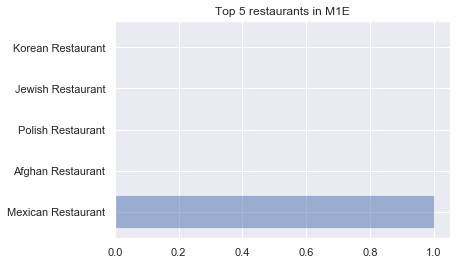

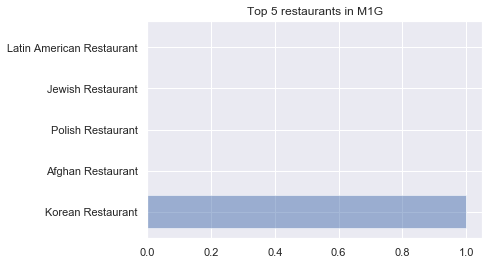

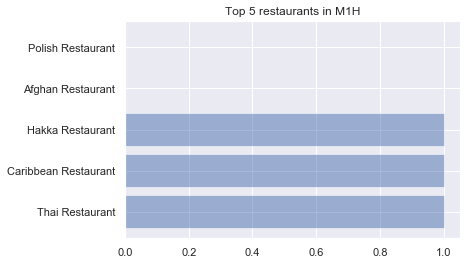

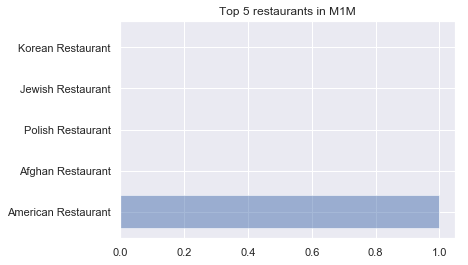

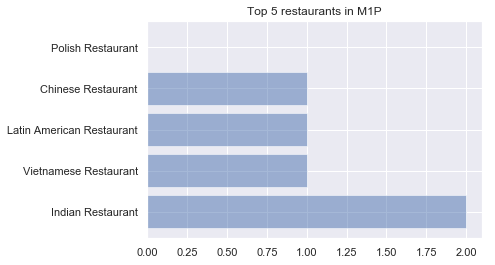

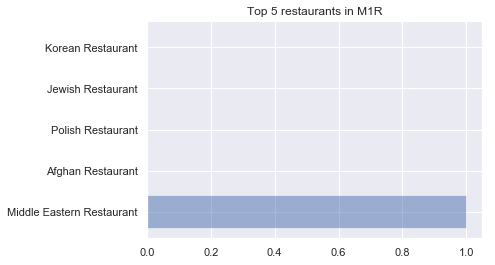

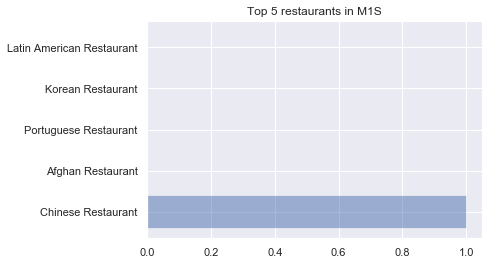

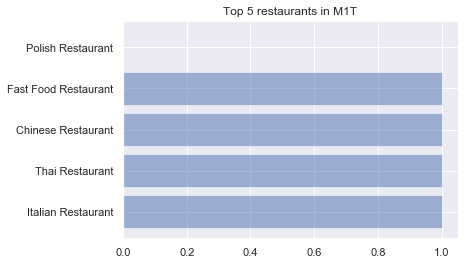

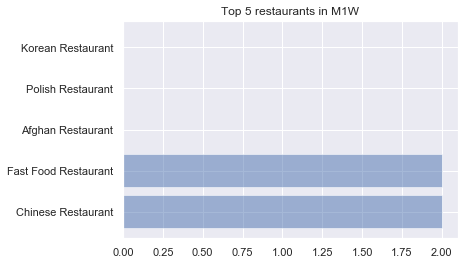

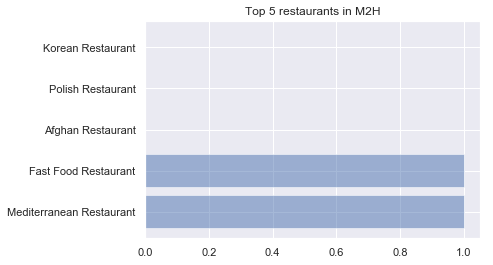

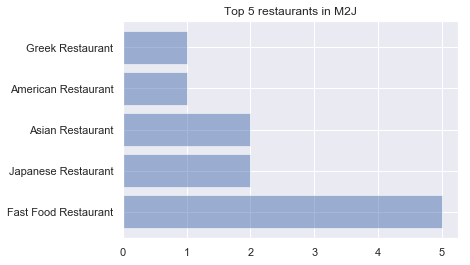

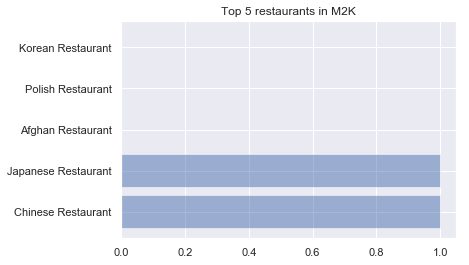

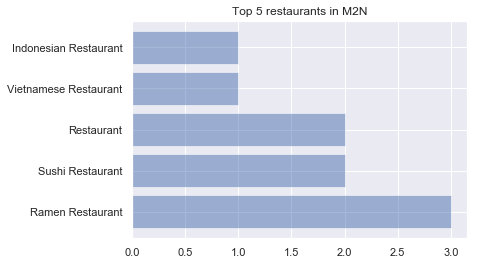

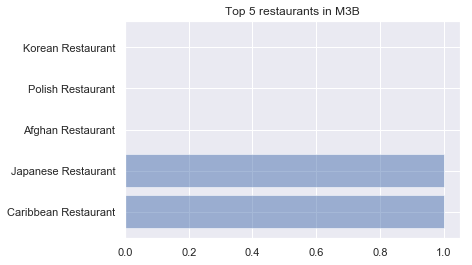

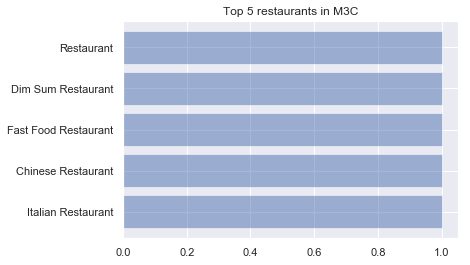

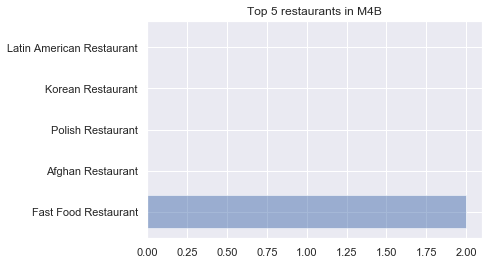

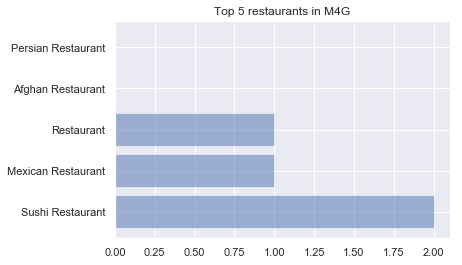

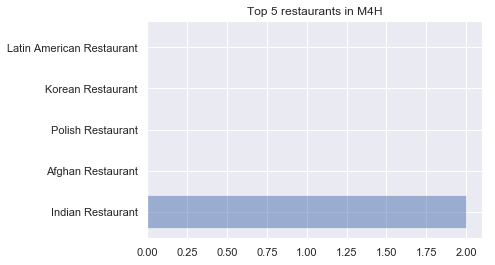

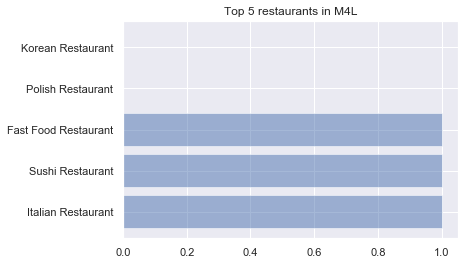

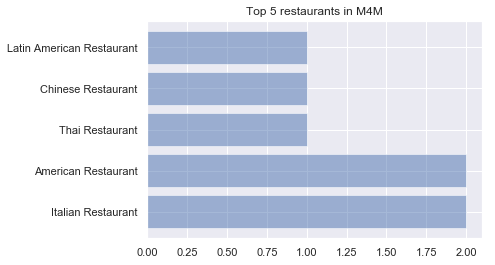

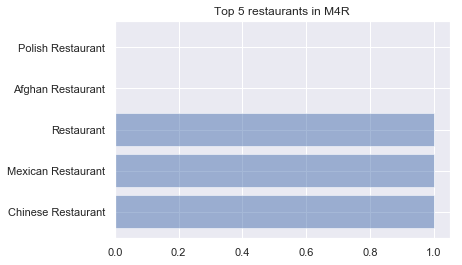

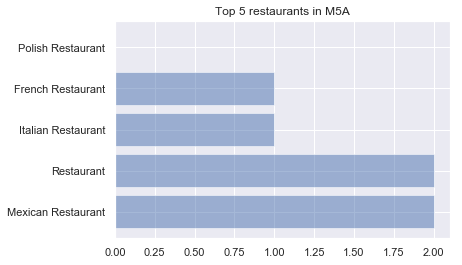

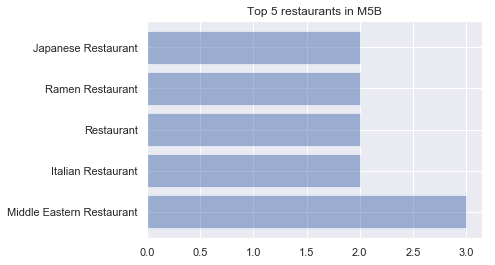

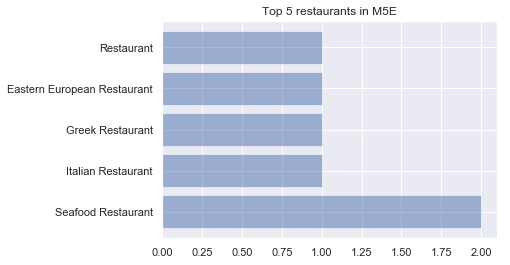

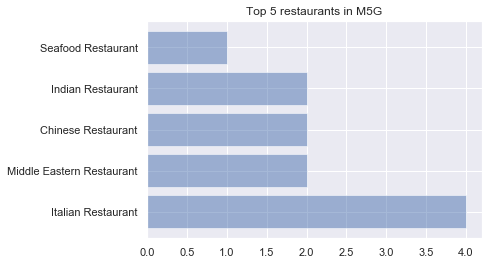

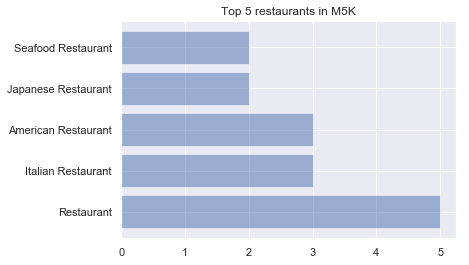

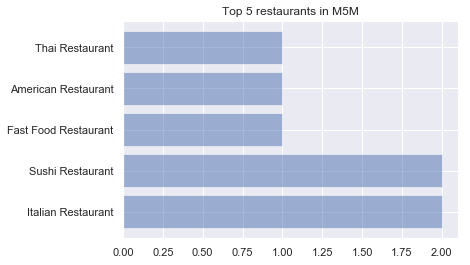

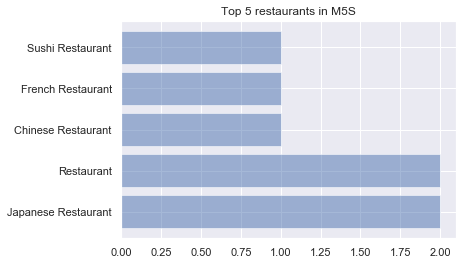

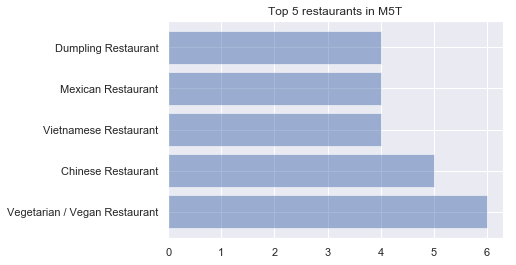

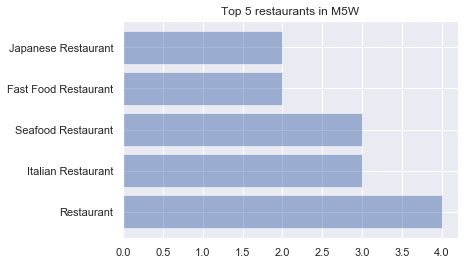

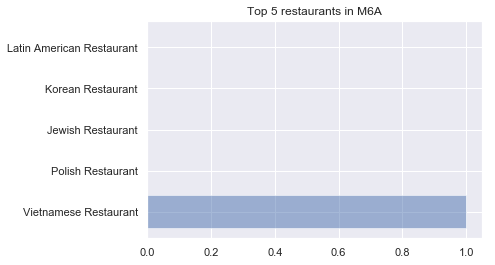

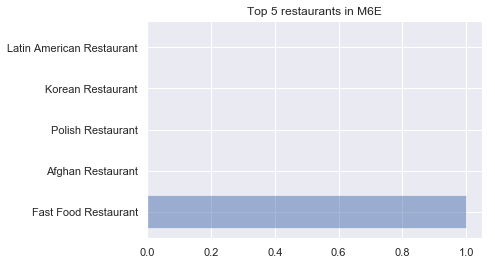

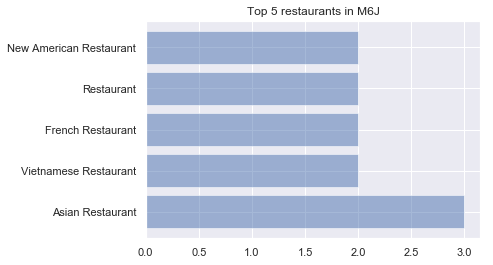

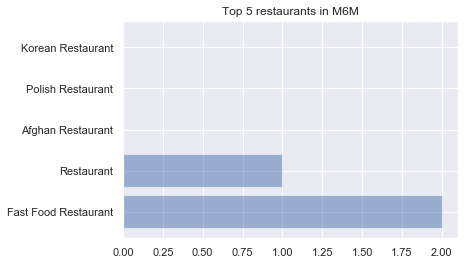

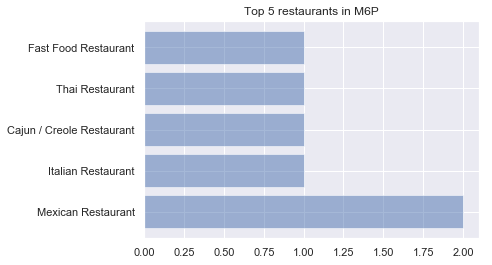

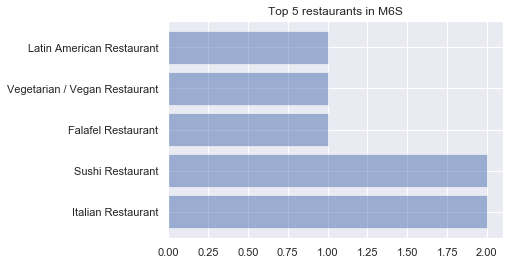

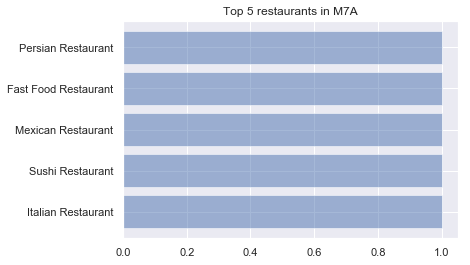

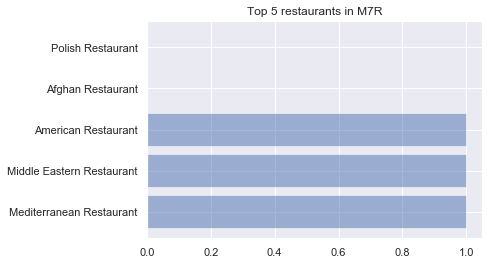

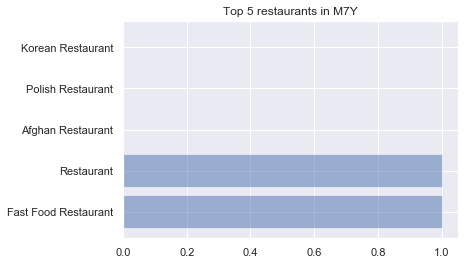

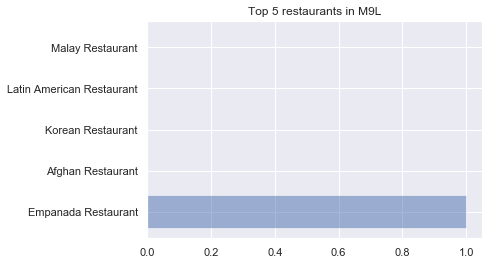

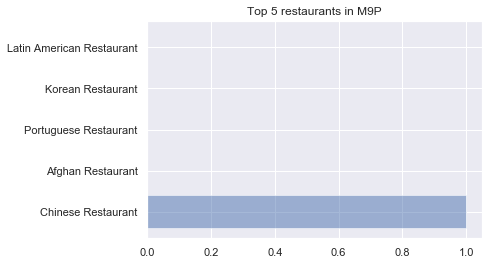

In [27]:
# Plotting all postal codes

for index, row in top_restaurants.iterrows():
    plotTop5(row)



### As we can see here many neighborhoods don't have more than one restaurant. Let's try to isolate the neighborhoods that have at least 5 restaurants total.

In [28]:
best_top_restaurants = pd.DataFrame(columns=top_restaurant_columns)

best_top_restaurants.head()

Empty DataFrame
Columns: [PostalCode, Top1Category, Top1Count, Top2Category, Top2Count, Top3Category, Top3Count, Top4Category, Top4Count, Top5Category, Top5Count]
Index: []

In [29]:
min_total_restaurants = 5

for index, row in top_restaurants.iterrows():
    
    temp_total_restaurants = sum([row['Top1Count'],row['Top2Count'],row['Top3Count'],row['Top4Count'],row['Top5Count']])

    if (temp_total_restaurants >= min_total_restaurants):
        best_top_restaurants = best_top_restaurants.append({'PostalCode': row['PostalCode'],
                                          'Top1Category': row['Top1Category'],
                                          'Top1Count': row['Top1Count'],
                                          'Top2Category': row['Top2Category'],
                                          'Top2Count': row['Top2Count'],
                                          'Top3Category': row['Top3Category'],
                                          'Top3Count': row['Top3Count'],
                                          'Top4Category': row['Top4Category'],
                                          'Top4Count': row['Top4Count'],
                                          'Top5Category': row['Top3Category'],
                                          'Top5Count': row['Top5Count']}, ignore_index=True)

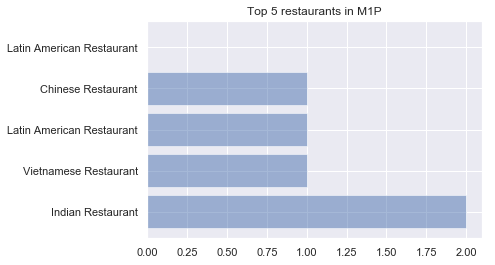

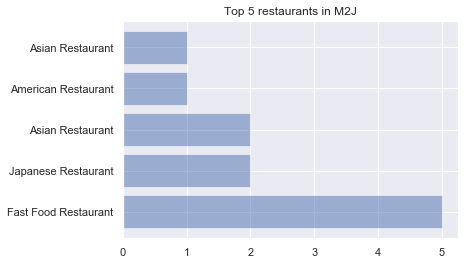

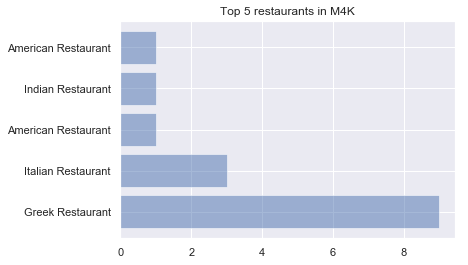

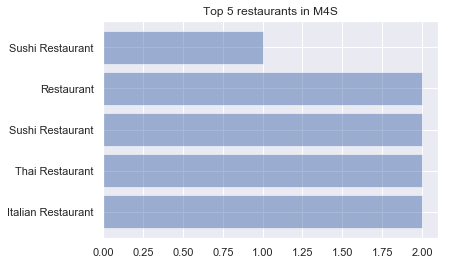

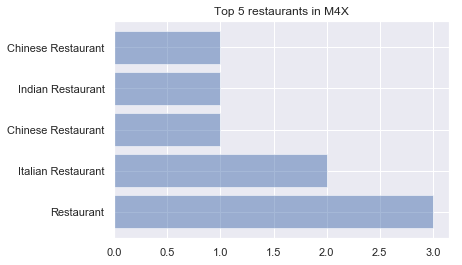

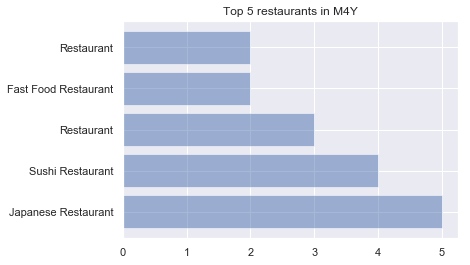

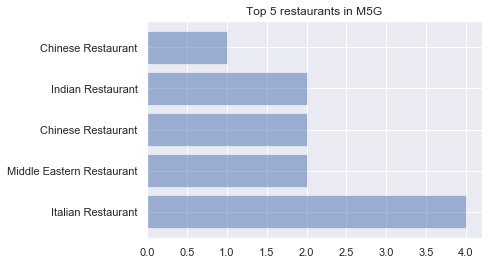

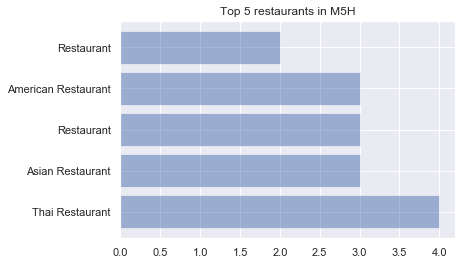

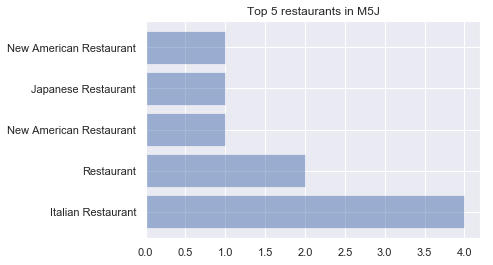

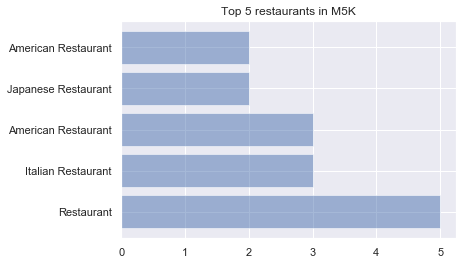

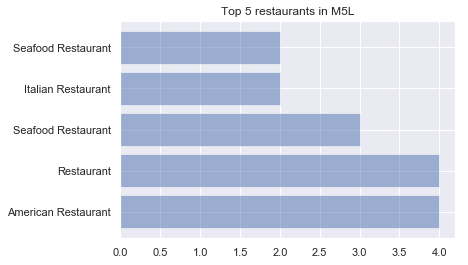

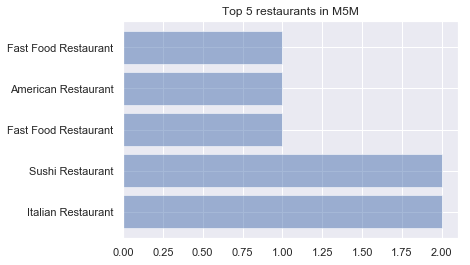

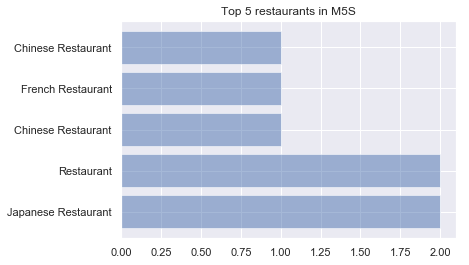

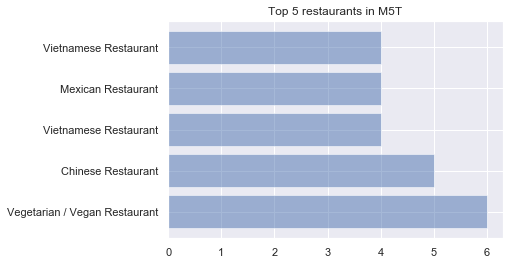

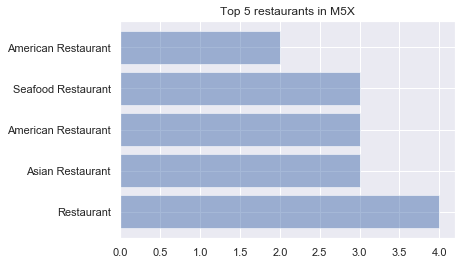

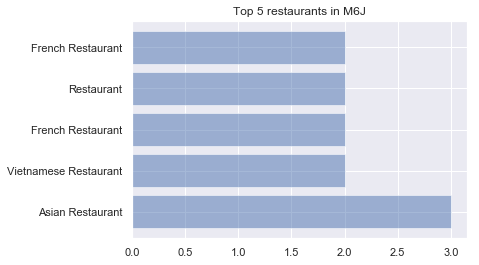

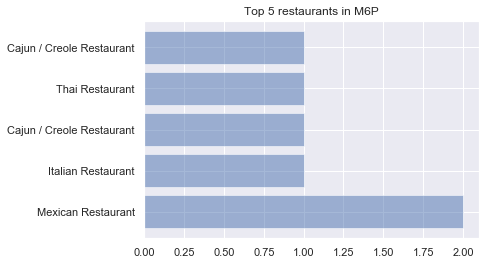

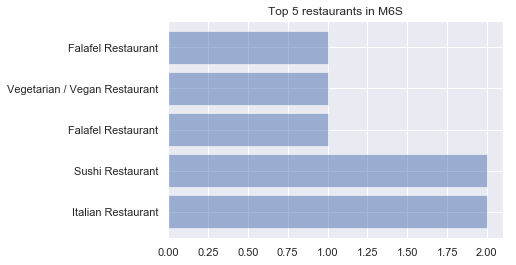

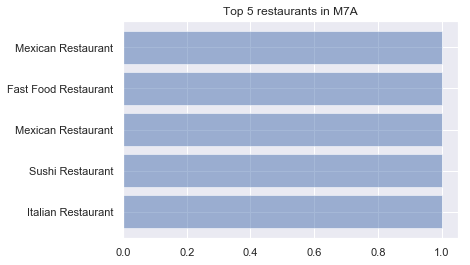

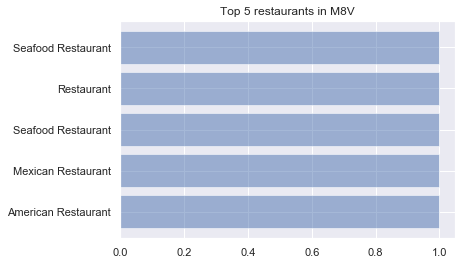

In [30]:
# Plotting top restaurants only in the best neighhborhoods
for index, row in best_top_restaurants.iterrows():
    plotTop5(row)



In [31]:
best_top_restaurants

PostalCode                   Top1Category  Top1Count  \
0         M1P              Indian Restaurant        2.0   
1         M2J           Fast Food Restaurant        5.0   
2         M2N               Ramen Restaurant        3.0   
3         M3C             Italian Restaurant        1.0   
4         M4K               Greek Restaurant        9.0   
5         M4M             Italian Restaurant        2.0   
6         M4S             Italian Restaurant        2.0   
7         M4X                     Restaurant        3.0   
8         M4Y            Japanese Restaurant        5.0   
9         M5A             Mexican Restaurant        2.0   
10        M5B      Middle Eastern Restaurant        3.0   
11        M5C             Italian Restaurant        5.0   
12        M5E             Seafood Restaurant        2.0   
13        M5G             Italian Restaurant        4.0   
14        M5H                Thai Restaurant        4.0   
15        M5J             Italian Restaurant        4.0   
16        M5K                     Restaurant        5.0   
17        M5L            American Restaurant        4.0   
18        M5M             Italian Restaurant        2.0   
19        M5S            Japanese Restaurant        2.0   
20        M5T  Vegetarian / Vegan Restaurant        6.0   
21        M5W                     Restaurant        4.0   
22        M5X                     Restaurant        4.0   
23        M6J               Asian Restaurant        3.0   
24        M6P             Mexican Restaurant        2.0   
25        M6S             Italian Restaurant        2.0   
26        M7A             Italian Restaurant        1.0   
27        M8V            American Restaurant        1.0   

                 Top2Category  Top2Count               Top3Category  \
0       Vietnamese Restaurant        1.0  Latin American Restaurant   
1         Japanese Restaurant        2.0           Asian Restaurant   
2            Sushi Restaurant        2.0                 Restaurant   
3          Chinese Restaurant        1.0       Fast Food Restaurant   
4          Italian Restaurant        3.0        American Restaurant   
5         American Restaurant        2.0            Thai Restaurant   
6             Thai Restaurant        2.0           Sushi Restaurant   
7          Italian Restaurant        2.0         Chinese Restaurant   
8            Sushi Restaurant        4.0                 Restaurant   
9                  Restaurant        2.0         Italian Restaurant   
10         Italian Restaurant        2.0                 Restaurant   
11                 Restaurant        5.0         Seafood Restaurant   
12         Italian Restaurant        1.0           Greek Restaurant   
13  Middle Eastern Restaurant        2.0         Chinese Restaurant   
14           Asian Restaurant        3.0                 Restaurant   
15                 Restaurant        2.0    New American Restaurant   
16         Italian Restaurant        3.0        American Restaurant   
17                 Restaurant        4.0         Seafood Restaurant   
18           Sushi Restaurant        2.0       Fast Food Restaurant   
19                 Restaurant        2.0         Chinese Restaurant   
20         Chinese Restaurant        5.0      Vietnamese Restaurant   
21         Italian Restaurant        3.0         Seafood Restaurant   
22           Asian Restaurant        3.0        American Restaurant   
23      Vietnamese Restaurant        2.0          French Restaurant   
24         Italian Restaurant        1.0  Cajun / Creole Restaurant   
25           Sushi Restaurant        2.0         Falafel Restaurant   
26           Sushi Restaurant        1.0         Mexican Restaurant   
27         Mexican Restaurant        1.0         Seafood Restaurant   

    Top3Count                   Top4Category  Top4Count  \
0         1.0             Chinese Restaurant        1.0   
1         2.0            American Restaurant        1.0   
2         2.0          Vietnamese Restaurant        1.

In [32]:
best_restaurants_loc_columns=['PostalCode','TotalRestaurants', 'Latitude', 'Longitude']
best_restaurants_loc = pd.DataFrame(columns=best_restaurants_loc_columns)

best_restaurants_loc.head()

Empty DataFrame
Columns: [PostalCode, TotalRestaurants, Latitude, Longitude]
Index: []

In [33]:

for hood in best_top_restaurants['PostalCode']:
   
    temp_rest = best_top_restaurants[best_top_restaurants['PostalCode'] == hood]
    temp_sum = sum([temp_rest['Top1Count'],temp_rest['Top2Count'],temp_rest['Top3Count'],temp_rest['Top4Count'],temp_rest['Top5Count']])
    temp_post = postalcodes[postalcodes['PostalCode'] == hood]
    best_restaurants_loc = best_restaurants_loc.append({'PostalCode': hood,
                                          'TotalRestaurants': temp_sum.values[0],
                                          'Latitude': temp_post['Latitude'].values[0],
                                          'Longitude': temp_post['Longitude'].values[0]}, ignore_index=True)
    
best_restaurants_loc.head()

PostalCode  TotalRestaurants   Latitude  Longitude
0        M1P               5.0  43.757410 -79.273304
1        M2J              11.0  43.778517 -79.346556
2        M2N               9.0  43.770120 -79.408493
3        M3C               5.0  43.725900 -79.340923
4        M4K              15.0  43.679557 -79.352188

In [140]:
# create map of Toronto using latitude and longitude values
map_best_restaurants_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, restaurants in zip(best_restaurants_loc['Latitude'], best_restaurants_loc['Longitude'], best_restaurants_loc['TotalRestaurants']):
    label = '{}'.format(restaurants)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_restaurants_toronto)  
    
map_best_restaurants_toronto

### Conclusion: Observational results seem to point at 27 good candidate neighborhoods in terms of sheer number of venues. Let's see if we can create a model that will further determine the best neighborhood for a restaurant.

# Section III: Model building

The purpose of this model is to determine the chances of success of a restaurant based on a neighborood.

The measure of success will be based on the rating of a venue.

The model we therefore be a linear regression model using location features of a restaurant (normalized by postal code) to determine this computed measure of success.


In [68]:
restaurant_stats_column = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID',
                  'Venue Rating',
                  'Venue Stats']

restaurant_stats = pd.DataFrame(columns=restaurant_stats_column)



In [70]:

for index, row in toronto_restaurants.iterrows():

    VENUE_ID = row['Venue ID']

    stats_url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        VENUE_ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    stats_url
    
    venue_results = requests.get(stats_url).json()['response']['venue']
    if 'rating' in venue_results:
        rating = venue_results['rating']
    else: 
        rating = 0.0


    if 'stats' in venue_results:
        stats = venue_results['stats']
    else: 
        stats = 'no stats'

    restaurant_stats = restaurant_stats.append({'PostalCode': row['PostalCode'],
                                          'PostalCode Latitude': row['PostalCode Latitude'],
                                          'PostalCode Longitude': row['PostalCode Longitude'],
                                          'Venue': row['Venue'],
                                          'Venue Latitude': row['Venue Latitude'],
                                          'Venue Longitude': row['Venue Longitude'],
                                          'Venue Category': row['Venue Category'],
                                          'Venue ID': row['Venue ID'],
                                          'Venue Rating': rating,
                                          'Venue Stats': stats}, ignore_index=True)
restaurant_stats

KeyError: 'venue'

## IMPORTANT: I reached the maximum of 500 premium/calls per day, so I was only able to collect the rating of these venues; this impacts the model training greatly.

In [76]:
restaurant_stats

PostalCode  PostalCode Latitude  PostalCode Longitude  \
0          M3A            43.753259            -79.329656   
1          M4A            43.725882            -79.315572   
2          M4A            43.725882            -79.315572   
3          M5A            43.654260            -79.360636   
4          M5A            43.654260            -79.360636   
5          M5A            43.654260            -79.360636   
6          M5A            43.654260            -79.360636   
7          M5A            43.654260            -79.360636   
8          M5A            43.654260            -79.360636   
9          M6A            43.718518            -79.464763   
10         M7A            43.662301            -79.389494   
11         M7A            43.662301            -79.389494   
12         M7A            43.662301            -79.389494   
13         M7A            43.662301            -79.389494   
14         M7A            43.662301            -79.389494   
15         M7A            43.662301            -79.389494   
16         M7A            43.662301            -79.389494   
17         M7A            43.662301            -79.389494   
18         M7A            43.662301            -79.389494   
19         M1B            43.806686            -79.194353   
20         M3B            43.745906            -79.352188   
21         M3B            43.745906            -79.352188   
22         M4B            43.706397            -79.309937   
23         M4B            43.706397            -79.309937   
24         M5B            43.657162            -79.378937   
25         M5B            43.657162            -79.378937   
26         M5B            43.657162            -79.378937   
27         M5B            43.657162            -79.378937   
28         M5B            43.657162            -79.378937   
29         M5B            43.657162            -79.378937   
..         ...                  ...                   ...   
451        M5W            43.646435            -79.374846   
452        M5W            43.646435            -79.374846   
453        M5W            43.646435            -79.374846   
454        M5W            43.646435            -79.374846   
455        M5W            43.646435            -79.374846   
456        M5W            43.646435            -79.374846   
457        M4X            43.667967            -79.367675   
458        M4X            43.667967            -79.367675   
459        M4X            43.667967            -79.367675   
460        M4X            43.667967            -79.367675   
461        M4X            43.667967            -79.367675   
462        M4X            43.667967            -79.367675   
463        M4X            43.667967            -79.367675   
464        M4X            43.667967            -79.367675   
465        M4X            43.667967            -79.367675   
466        M4X            43.667967            -79.367675   
467        M4X            43.667967            -79.367675   
468        M5X            43.648429            -79.382280   
469        M5X            43.648429            -79.382280   
470        M5X            43.648429            -79.382280   
471        M5X            43.648429            -79.382280   
472        M5X            43.648429            -79.382280   
473        M5X            43.648429            -79.382280   
474        M5X            43.648429            -79.382280   
475        M5X            43.648429            -79.382280   
476        M5X            43.648429            -79.382280   
477        M5X            43.648429            -79.382280   
478        M5X            43.648429            -79.382280   
479        M5X            43.648429            -79.382280   
480        M5X            43.648429            -79.382280   

                                    Venue  Venue Latitude  Venue Longitude  \
0                                     KFC       43.754387       -79.333021   
1                               Portugril       43.725819       -

In [77]:
restaurant_stats.sort_values('Venue Rating')

PostalCode  PostalCode Latitude  PostalCode Longitude  \
311        M6M            43.691116            -79.476013   
23         M4B            43.706397            -79.309937   
363        M4S            43.704324            -79.388790   
94         M1G            43.770992            -79.216917   
430        M8V            43.605647            -79.501321   
429        M8V            43.605647            -79.501321   
362        M4S            43.704324            -79.388790   
350        M7R            43.636966            -79.615819   
82         M1E            43.763573            -79.188711   
176        M3J            43.767980            -79.487262   
351        M7R            43.636966            -79.615819   
211        M2K            43.786947            -79.385975   
175        M3J            43.767980            -79.487262   
174        M2J            43.778517            -79.346556   
173        M2J            43.778517            -79.346556   
172        M2J            43.778517            -79.346556   
349        M7R            43.636966            -79.615819   
352        M1S            43.794200            -79.262029   
337        M1R            43.750072            -79.295849   
309        M6M            43.691116            -79.476013   
322        M2N            43.770120            -79.408493   
2          M4A            43.725882            -79.315572   
466        M4X            43.667967            -79.367675   
323        M2N            43.770120            -79.408493   
128        M2H            43.803762            -79.363452   
8          M5A            43.654260            -79.360636   
127        M2H            43.803762            -79.363452   
364        M4S            43.704324            -79.388790   
171        M2J            43.778517            -79.346556   
308        M5M            43.733283            -79.419750   
..         ...                  ...                   ...   
399        M5T            43.653206            -79.400049   
54         M5C            43.651494            -79.375418   
29         M5B            43.657162            -79.378937   
213        M4K            43.679557            -79.352188   
459        M4X            43.667967            -79.367675   
212        M4K            43.679557            -79.352188   
468        M5X            43.648429            -79.382280   
259        M5L            43.648198            -79.379817   
365        M5S            43.662696            -79.400049   
193        M6J            43.647927            -79.419750   
229        M5K            43.647177            -79.381576   
57         M5C            43.651494            -79.375418   
341        M5R            43.672710            -79.405678   
56         M5C            43.651494            -79.375418   
148        M5H            43.650571            -79.384568   
194        M6J            43.647927            -79.419750   
192        M6J            43.647927            -79.419750   
200        M6J            43.647927            -79.419750   
267        M5L            43.648198            -79.379817   
191        M6J            43.647927            -79.419750   
330        M6P            43.661608            -79.464763   
60         M5C            43.651494            -79.375418   
195        M6J            43.647927            -79.419750   
179        M5J            43.640816            -79.381752   
478        M5X            43.648429            -79.382280   
147        M5H            43.650571            -79.384568   
387        M5T            43.653206            -79.400049   
366        M5S            43.662696            -79.400049   
146        M5H            43.650571            -79.384568   
149        M5H            43.650571            -79.384568   

                                 Venue  Venue Latitude  Venue Longitude  \
311             New York Fried Chicken       43.688473       -79.480948   
23                            Harvey's       43.708136       -79.314105

In [127]:

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


regr = linear_model.LinearRegression()
X = restaurant_stats[['Venue Latitude','Venue Longitude']]
y = restaurant_stats['Venue Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))


Coefficients: 
 [-24.20225322  11.92902439]
Mean squared error: 2.81
Variance score: 0.38


# Section IV: Predictions

Now that we have a model, let's see how much anticipated ratings we would have per PostalCode

In [128]:
prediction_columns = ['PostalCode', 'Latitude', 'Longitude', 'Predicted Rating']
prediction = pd.DataFrame(columns=prediction_columns)
prediction.head()

Empty DataFrame
Columns: [PostalCode, Latitude, Longitude, Predicted Rating]
Index: []

In [129]:
distinct_codes = restaurant_stats['PostalCode'].unique()



for i in range(len(distinct_codes)):
    post_code = distinct_codes[i]
    post_latitude = restaurant_stats.loc[restaurant_stats['PostalCode'] == post_code]['PostalCode Latitude'].values[0]
    post_longitude = restaurant_stats.loc[restaurant_stats['PostalCode'] == post_code]['PostalCode Longitude'].values[0]
    predicted_rating = regr.predict([[post_latitude,post_longitude]])[0]
    
    prediction = prediction.append({'PostalCode': post_code,
                                          'Latitude': post_latitude,
                                          'Longitude': post_longitude,
                                          'Predicted Rating': predicted_rating}, ignore_index=True)
    
prediction.head()

PostalCode   Latitude  Longitude  Predicted Rating
0        M3A  43.753259 -79.329656          5.932623
1        M4A  43.725882 -79.315572          6.763211
2        M5A  43.654260 -79.360636          7.959061
3        M6A  43.718518 -79.464763          5.161732
4        M7A  43.662301 -79.389494          7.420190

In [141]:
# create map of Toronto using latitude and longitude values
map_pred_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# add markers to map
for lat, lng, rating in zip(prediction['Latitude'], prediction['Longitude'], prediction['Predicted Rating']):
    label = '{}'.format(rating)
    label = folium.Popup(label, parse_html=True)
    if rating < 5:
        color = 'red'
    elif (rating > 5 and rating < 7):
        color = 'orange'
    else: 
        color = 'green'
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=1,
        parse_html=False).add_to(map_pred_toronto)  
    
map_pred_toronto

# Conclusion

In conclusion, the model of rating seems to be in accordance with the number of restaurants in Toronto: the most popular predicted ratings are in the same area where most restaurants are!